## Driver code comparing output of different preproc pipelines 
- Note: currently using output after atlas-based grouping
- Atlas used: aparc (Freesurfer) DKT-31 Mindboggle (ANTs: https://mindboggle.readthedocs.io/en/latest/labels.html) 

### Steps
- import data csvs 
- visualize data distributions 
- correlate features across pipelines
- compare performance of machine-learning model (scikit-learn)
- compare performance of statsmodels (ols or logit)

In [1]:
import sys
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

sys.path.append('../')
from lib.data_handling import *
from lib.data_stats import *

### Data paths

In [2]:
proj_dir = '/home/nikhil/projects/CT_reproduce/code/compare-surf-tools/'
#proj_dir = '/Users/nikhil/projects/compare-surf-tools/'
data_dir = proj_dir + 'data/'
fs60_dir = data_dir + 'fs60_group_stats/'
qc_dir =  '/home/nikhil/projects/CT_reproduce/data/QC/'
results_dir = data_dir + 'results/'

demograph_file = 'ABIDE_Phenotype.csv'
dkt_roi_names = '/DKT/DKT_parcel_map_FS_CIVET.csv'

ants_file = 'ABIDE_ants_thickness_data.csv' #uses modified (mindboggle) dkt atlas with 31 ROIs
civet_file = 'ABIDE_civet2.1_thickness.csv'

fs53_file = 'ABIDE_fs5.3_thickness.csv'
fs51_file = 'cortical_fs5.1_measuresenigma_thickavg.csv' 
fs60_lh_file = 'lh.aparc.thickness.table.test1' #'aparc_lh_thickness_table.txt' #'lh.aparc.thickness.table.test1'
fs60_rh_file = 'rh.aparc.thickness.table.test1' #'aparc_rh_thickness_table.txt' #'rh.aparc.thickness.table.test1'


### Global Vars

In [3]:
subject_ID_col = 'SubjID'

### Load data

In [4]:
# Demographics and Dx
demograph = pd.read_csv(data_dir + demograph_file)
demograph = demograph.rename(columns={'Subject_ID':subject_ID_col})

# ROI names
dkt_roi_map = pd.read_csv(data_dir + dkt_roi_names)

print('loading available datasets...\n')

# CIVET 2.1
civet_data = pd.read_csv(data_dir + civet_file, dtype={subject_ID_col: str})
print('shape of civet data {}'.format(civet_data.shape))
civet_data_std = standardize_civet_data(civet_data, subject_ID_col, dkt_roi_map)
print('shape of stdized civet data {}'.format(civet_data_std.shape))
print('')

# ANTs
ants_data = pd.read_csv(data_dir + ants_file, header=2)
print('shape of ants data {}'.format(ants_data.shape))
ants_data_std = standardize_ants_data(ants_data, subject_ID_col)
print('shape of stdized ants data {}'.format(ants_data_std.shape))
print('')

# FS
fs53_data = pd.read_csv(data_dir + fs53_file)
print('shape of fs53 data {}'.format(fs53_data.shape))
fs53_data_std = standardize_fs_data(fs53_data, subject_ID_col)
print('shape of stdized fs53 data {}'.format(fs53_data_std.shape))
print('')

fs51_data = pd.read_csv(data_dir + fs51_file)
print('shape of fs51 data {}'.format(fs51_data.shape))
fs51_data_std = standardize_fs_data(fs51_data, subject_ID_col)
print('shape of stdized fs51 data {}'.format(fs51_data_std.shape))
print('')

fs60_lh_data = pd.read_csv(fs60_dir + fs60_lh_file, delim_whitespace=True)
fs60_rh_data = pd.read_csv(fs60_dir + fs60_rh_file, delim_whitespace=True)
print('shape of fs60 data l: {}, r: {}'.format(fs60_lh_data.shape,fs60_rh_data.shape))

fs60_data_std = standardize_fs60_data(fs60_lh_data, fs60_rh_data, subject_ID_col)
print('shape of stdized fs60 data {}'.format(fs60_data_std.shape))

loading available datasets...

shape of civet data (899, 65)
shape of stdized civet data (899, 65)

shape of ants data (1101, 99)
shape of stdized ants data (1101, 90)

shape of fs53 data (976, 74)
shape of stdized fs53 data (976, 74)

shape of fs51 data (1112, 74)
shape of stdized fs51 data (1112, 74)

shape of fs60 data l: (1047, 36), r: (1047, 36)
shape of left and right merge fs6.0 df (1047, 71)
shape of stdized fs60 data (1047, 71)


### Create master dataframe

In [5]:
data_dict = {'civet': civet_data_std,
            'ants' : ants_data_std,
            'fs60' : fs60_data_std,
            'fs53' : fs53_data_std,
            'fs51' : fs51_data_std}

na_action = 'drop' # options: ignore, drop; anything else will not use the dataframe for analysis. 
master_df_raw, common_subs, common_roi_cols = combine_processed_data(data_dict, subject_ID_col, na_action)

# Add demographic columns to the master_df_raw
useful_demograph = demograph[[subject_ID_col,'SEX','AGE_AT_SCAN','DX_GROUP','SITE_ID']].copy()

# DX_GROUP: (orginal: 1:ASD, 2:Controls, after shift 0:ASD, 1:Controls)
# Shift to (0 and 1 instead of 1 and 2 for statsmodels)
#useful_demograph['DX_GROUP'] = useful_demograph['DX_GROUP']-1
# Replace to (2 with 0 for statsmodels) (1:ASD, 0:Controls)
useful_demograph['DX_GROUP'] = useful_demograph['DX_GROUP'].replace({2:0})
useful_demograph['SEX'] = useful_demograph['SEX']-1
_,useful_demograph[subject_ID_col] = useful_demograph[subject_ID_col].str.rsplit('_', 1).str

master_df_raw = pd.merge(master_df_raw, useful_demograph, how='left', on=subject_ID_col)

print('\nmaster df shape after adding demographic info {}'.format(master_df_raw.shape))
print('\nNumber of common subjects {}({}), ROIs {}'.format(len(common_subs), master_df_raw[master_df_raw['pipeline']=='fs60']['DX_GROUP'].value_counts().to_dict(),len(common_roi_cols)))


Number of datasets: 5
Finding common subject and columns
dataset : fs51
common subs: 1112
dataset : ants
common subs: 1101
dataset : fs53
common subs: 975
dataset : civet
common subs: 800
dataset : fs60
common subs: 778
Number of common subjects and columns: 778, 63

checking fs51 dataframe
Shape of the dataframe based on common cols and subs (778, 63)
Basic data check passed
Shape of the concat dataframe (778, 64)

checking ants dataframe
Shape of the dataframe based on common cols and subs (778, 63)
Basic data check passed
Shape of the concat dataframe (1556, 64)

checking fs53 dataframe
Shape of the dataframe based on common cols and subs (778, 63)
Basic data check passed
Shape of the concat dataframe (2334, 64)

checking civet dataframe
Shape of the dataframe based on common cols and subs (778, 63)
Basic data check passed
Shape of the concat dataframe (3112, 64)

checking fs60 dataframe
Shape of the dataframe based on common cols and subs (778, 63)
Basic data check passed
Shape of 

### QC filters
- Manual (Gleb or Maarten)
- Automatic (Amadou) 

In [18]:
qc_type = 'None' #condition: master_df['QC_maarten']==0, master_df['QC_gleb'].isin['1','-+1']

if qc_type in ['maarten','gleb']:
    qc_df = pd.read_csv(qc_dir + 'master_QC_table.csv',dtype={'SubjID': str})
    master_df = pd.merge(master_df_raw, qc_df, how='left', on=subject_ID_col)
    # This generate NaNs since qc_df doesn't have all subjects in the master_df
    # Current implementation will discard these NaN subjects if QC is used 
    if qc_type == 'maarten':
        master_df = master_df[master_df['QC_maarten']==0]    
    elif qc_type == 'gleb':
        master_df = master_df[master_df['QC_gleb'].isin(['1','-+1'])]
    else:
        print('unknown qc_type')
    
    print('Filtering based on {} QC. Resultant number of subjects {} ({}) (out of {})'.format(qc_type,len(master_df[subject_ID_col].unique()),master_df[master_df['pipeline']=='fs60']['DX_GROUP'].value_counts().to_dict(),len(common_subs)))
    common_subs = master_df[subject_ID_col].unique()
else:
    master_df = master_df_raw
    print('No QC performed. master_df shape {}'.format(len(master_df[subject_ID_col].unique())))
    
# Check for minimum sample size requirement for covariates, especially SITE_ID
covars_to_check = ['SITE_ID']
min_sample_req = 3 #at least N subject per site (per pipeline)
min_count = min_sample_req*len(master_df['pipeline'].unique()) 
print('\nPerforming min sample (N_min={}) size check'.format(min_sample_req))
for covar in covars_to_check:
    counts = master_df[covar].value_counts()
    master_df = master_df[master_df[covar].isin(counts[counts > min_count].index)]
    print("Dropping {} {}".format(covar,counts[counts <= min_count]))

print('Resultant number of subjects {} ({}) (out of {})'.format(qc_type,len(master_df[subject_ID_col].unique()),master_df[master_df['pipeline']=='fs60']['DX_GROUP'].value_counts().to_dict(),len(common_subs)))
common_subs = master_df[subject_ID_col].unique()

No QC performed. master_df shape 778

Performing min sample (N_min=3) size check
Dropping SITE_ID Series([], Name: SITE_ID, dtype: int64)
Resultant number of subjects None (778) (out of {0: 415, 1: 363})


### Correlation between pipelines

In [15]:
possible_pairs = list(itertools.combinations(data_dict.keys(), 2))
xcorr_pairs_df = pd.DataFrame()
for pair in possible_pairs:
    pipe1 = pair[0]
    pipe2 = pair[1]
    df1 = master_df[master_df['pipeline']==pipe1][[subject_ID_col]+common_roi_cols]
    df2 = master_df[master_df['pipeline']==pipe2][[subject_ID_col]+common_roi_cols]
    xcorr_df = cross_correlations(df1,df2,subject_ID_col)
    xcorr_df['pipeline_pair'] = np.tile(str('{}-{}'.format(pair[0],pair[1])),len(xcorr_df))
    xcorr_pairs_df = xcorr_pairs_df.append(xcorr_df)
    print('Avg cross correlation between {} & {} = {:4.2f}\n'.format(pipe1,pipe2,np.mean(xcorr_df['correlation'].values)))
    

Avg cross correlation between fs51 & ants = 0.43

Avg cross correlation between fs51 & fs53 = 0.90

Avg cross correlation between fs51 & civet = 0.48

Avg cross correlation between fs51 & fs60 = 0.86

Avg cross correlation between ants & fs53 = 0.48

Avg cross correlation between ants & civet = 0.42

Avg cross correlation between ants & fs60 = 0.43

Avg cross correlation between fs53 & civet = 0.52

Avg cross correlation between fs53 & fs60 = 0.91

Avg cross correlation between civet & fs60 = 0.51



Shape of cross-corr df (620, 3), number of pairs 10


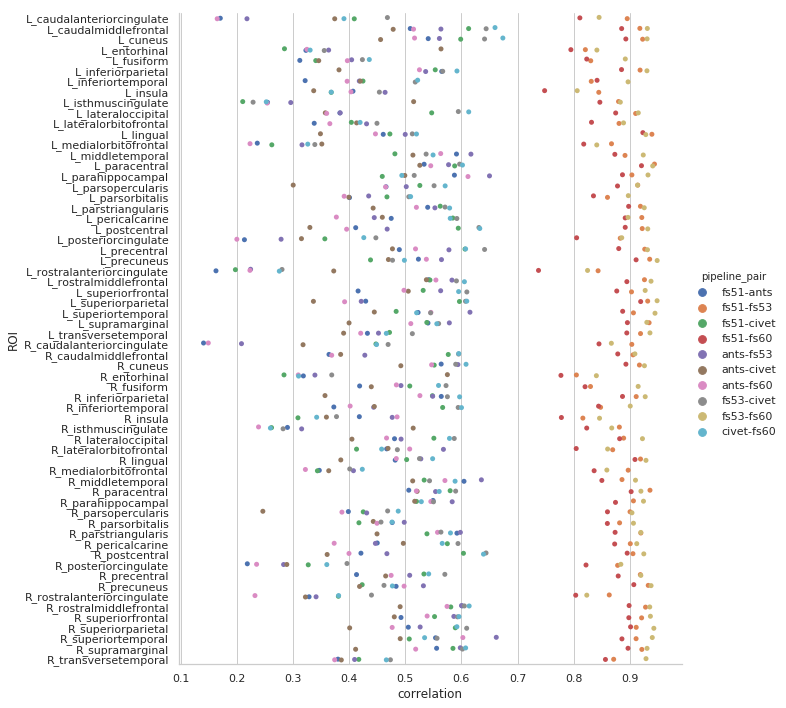

In [16]:
print('Shape of cross-corr df {}, number of pairs {}'.format(xcorr_pairs_df.shape, len(xcorr_pairs_df['pipeline_pair'].unique())))
roi_order = sorted(list(xcorr_pairs_df['ROI'].unique()))
sns.set(font_scale=1)
with sns.axes_style("whitegrid"):
    g = sns.catplot(x='correlation',y='ROI',hue='pipeline_pair',order=roi_order,
                data=xcorr_pairs_df,aspect=1,height=10,kind='strip')

### Covariance / Correlation between ROIs

Shapes df (194, 63), df_corr (62, 62)


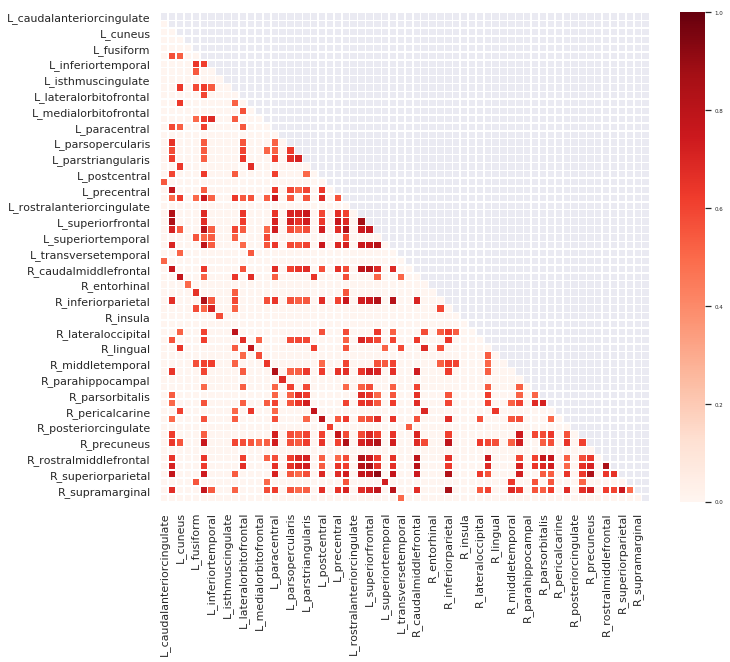

In [9]:
p_thresh= 0.05/(62*62/2) #Rough number of comparisons 
r_thresh = 0.5 #Look at only high correlations 

pipe = 'fs60'
df = master_df[master_df['pipeline']==pipe][[subject_ID_col]+common_roi_cols]
df_sorted = df.reindex(sorted(df.columns), axis=1)

corr = df_sorted.corr()
df_p_val = calculate_pvalues(df_sorted)
corr[df_p_val >= p_thresh] = 0
corr[corr < r_thresh] = 0
print('Shapes df {}, df_corr {}'.format(df.shape,corr.shape))

# Plot
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = 'Reds'#sns.diverging_palette(220, 10, as_cmap=True)


with sns.axes_style("white"):
    sns.set(font_scale=0.5)
    g = sns.heatmap(corr, mask=mask, cmap=cmap, square=True, linewidths=.5)


### Compare ML performance 

In [ ]:
roi_cols = common_roi_cols

model_type = 'classification'

if model_type.lower() == 'regression':
    outcome_col = 'AGE_AT_SCAN'
    covar_continuous_cols = []
    covar_cat_cols = ['SEX','SITE_ID','DX_GROUP'] 
    model = RandomForestRegressor(max_depth=2, random_state=0, n_estimators=50)
else: 
    outcome_col = 'DX_GROUP'
    covar_continuous_cols = ['AGE_AT_SCAN']
    covar_cat_cols = ['SEX','SITE_ID'] 
    #model = svm.SVC(kernel='linear')
    model = RandomForestClassifier(n_estimators=50, max_depth=2,random_state=0)

ml_perf,perf_pval_dict = computePipelineMLModels(master_df,roi_cols,covar_continuous_cols,covar_cat_cols,
                                                 outcome_col,model_type,model)

Running ML classifer on 5 pipelines
Pipeline fs53
Using 1 continuous covar
Using 2 col for 11 cat covar
Data shapes X (194, 74), y 194 ([113, 81])
Using classification model with perf metric roc_auc


In [ ]:
print(perf_pval_dict)
#ml_perf['MSE'] = -1*ml_perf['neg_mean_squared_error']
x_order = ['fs51','fs53','fs60','ants','civet','null']
with sns.axes_style("white"): 
    g = sns.catplot(y='roc_auc',x='pipeline',kind='boxen',data=ml_perf, order=x_order)
    #g.set(ylim=(0, 80))


### Compare statsmodels performance 

In [19]:
save_sm_perf = False
roi_cols = common_roi_cols
covar_cols = [('DX_GROUP','cat'),('SEX','cat'),('SITE_ID','cat')]
outcome_col = ('roi','continuous') #'roi' #AGE_AT_SCAN #DX_GROUP 
signific_col = ('AGE_AT_SCAN','continuous') #('DX_GROUP','cat'),('roi','continuous') 
stat_model = 'ols' #ols #logit

sm_perf = computePipelineStatsModels(master_df,roi_cols,covar_cols,outcome_col,signific_col,stat_model)
print('Shape of the stats_models results df {}'.format(sm_perf.shape))

if save_sm_perf:
    save_path = '{}pipelines_sm_perf_{}_{}_{}_QC_{}_N_{}.pkl'.format(results_dir,outcome_col[0],signific_col[0],
                                                                     stat_model,qc_type,len(common_subs))
    print('Saving sm_perf dictionary at \n{}'.format(save_path))
    sm_perf.to_pickle(save_path)


Running 62 mass-univariate ols statsmodels on 5 pipelines
Pipeline fs51
Example statsmodel run:
 R_lateraloccipital ~ AGE_AT_SCAN + C(DX_GROUP) + C(SEX) + C(SITE_ID)
Top 10 significant regions:
                        roi      coef      t_val         p_val    p_val_corr  \
20             R_precuneus -0.017579 -18.871232  2.136281e-65  1.324494e-63   
47             L_precuneus -0.017677 -18.043898  8.244529e-61  2.555804e-59   
38      R_inferiorparietal -0.016995 -17.130954  7.617916e-56  1.574369e-54   
37      L_inferiorparietal -0.017915 -16.768897  6.613476e-54  1.025089e-52   
46  L_lateralorbitofrontal -0.018310 -15.790194  9.204867e-49  1.075086e-47   
31       L_superiorfrontal -0.017413 -15.779923  1.040406e-48  1.075086e-47   
59  R_rostralmiddlefrontal -0.016636 -15.404160  8.932259e-47  7.911429e-46   
60       R_superiorfrontal -0.017179 -15.071159  4.410937e-45  3.418476e-44   
53      R_superiorparietal -0.014653 -15.008239  9.169389e-45  5.706169e-44   
40      L_super